# AOS_singleAmpSep

# Star Separation Test on a single Amplifier

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are brought closer together,  possibly bringing us to the regime of overlapping donuts. We ensure that stars are simulated on a single amplifier, to avoid positioning on CCD edges where some non-uniformity in donut image could be due to the instrument signature removal (ISR) process, which is in constant improvement.

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/`. 

The exact steps:

    cd /epyc/users/suberlak/Commissioning/aos/
    source setup_aos_2020_15.sh 
    cd  ts_phosim/notebooks/analysis_scripts/
    python runSingleAmpStarSep.py


### Results

In [217]:
import os
from astropy.table import Table
import numpy as np

# IMPORT CUSTOM FUNCTIONS 
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics
import analysisTools as at 



%matplotlib inline


# IMPORT LSST MODULES 
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [210]:
%matplotlib inline

# setup the location of analysis files ... 
baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_after_centroid_update'
resDir = 'singleAmpSepNew'


Illustrate what we are doing (running the AOS loop 10 times, each time simulating two stars per CCD, with 9 ComCam CCDs) by plotting full image of several CCDs : 

In [211]:
sep=10
data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
image = at.readPostISRImage(data_dir, focalType = 'extra', raft = 'R22', detector = 'S00',)
centroid, centFlag = at.readCentroidInfo(data_dir, focalType='extra', raft='R22',detector='S00')


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_10
For sensor R22_S00 
Done

Reading centroid files from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_10/iter0/img/extra
Using  centroid_lsst_e_9006002_f1_R22_S00_E000.txt
[Errno 2] No such file or directory: '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_10/iter0/img/extra/centroid_lsst_e_9006002_f1_R22_S00_E000.txt'


Reading info about postage-stamp images from postagedonutStarsExtraIntra.txt


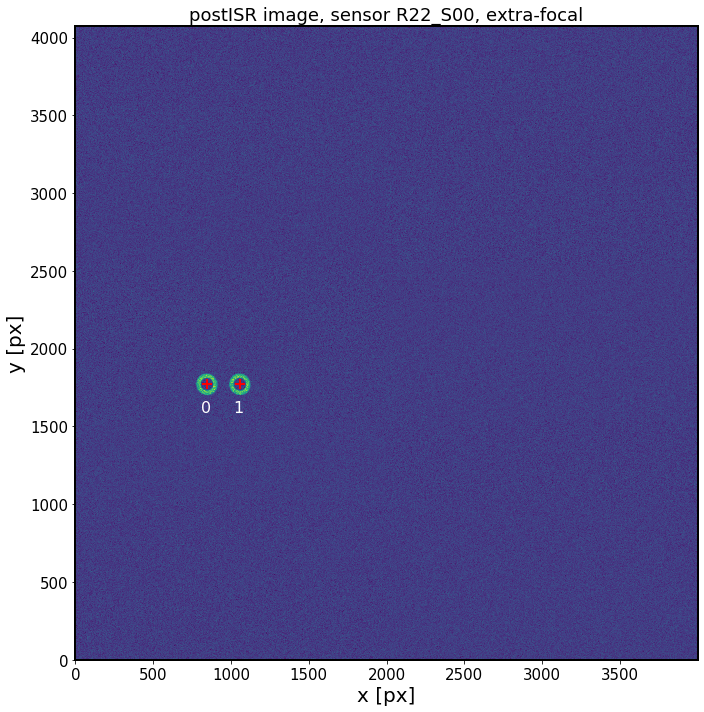

In [212]:
%matplotlib inline
postage, postFlag =  at.readPostageStars(data_dir)
at.plotImage(image,ax=None, log=False, sensor='R22_S00', focalType='extra',
          postage=postage,postFlag=postFlag, centroid=centFlag, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross')

First, plot root-mean-squared difference between wavefront estimation from `ts_wep`, and the OPD (truth) : 

10
9
8
7
6
5
4
3
2
1


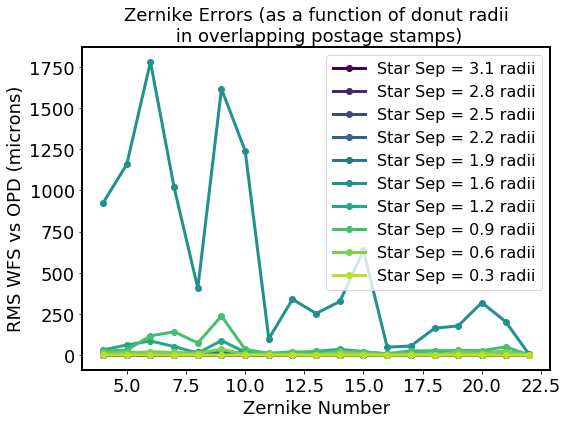

In [213]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


sepArr = np.arange(1,11)[::-1]

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 


for sep in sepArr :
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData
    wfsData = wfsData
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInRadii = sepInPercToRadii(sepArr[i])
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % sepInRadii,
             color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()


Let's step through parts:  

1) those stars that are far-away have good recovery of the wavefront: 

10
9
8


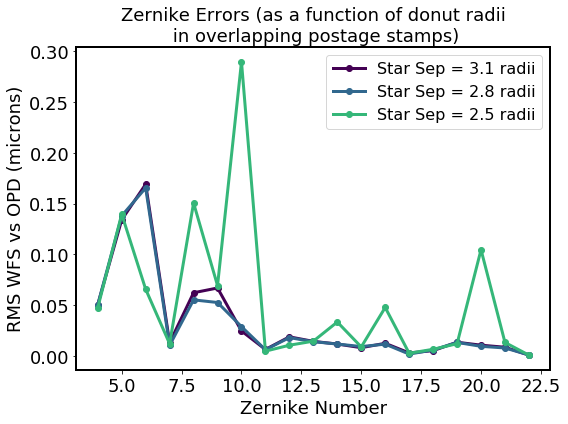

In [214]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()

sepArr = [10,9,8]

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

for sep in sepArr:
    print(sep)
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

fig = plt.figure(figsize=(8,6))

for i in range(len(sepArr)):
    sepInRadii = sepInPercToRadii(sepArr[i])
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %.1f radii' % sepInRadii,
             color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of donut radii\n in overlapping postage stamps)', size=18)
    
plt.tight_layout()


This picture from https://www.janssenprecisionengineering.com/wp-content/uploads/Zernike_modes_adapted.png illustrates which optical distortions these Zernikes correspond: 
    <img src='Zernike_modes_adapted.png'></img>

Plot wfs error for each star separation as well as postISR image to illustrate, for a particular intra-focal sensor

In [141]:
# Read each figure as a postage stamp, store data to an array 
images = {}
for sep in sepArr:
    data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
    images[sep] = at.readPostISRImage(data_dir, focalType = 'extra', obsId=None, raft = 'R22',
                     detector = 'S00', detNum = None, verbose=True)
    


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_10
For sensor R22_S00 
Done


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_9
For sensor R22_S00 
Done


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_8
For sensor R22_S00 
Done


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_7
For sensor R22_S00 
Done


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_6
For sensor R22_S00 
Done


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmp

<module 'analysisTools' from '../analysis_tools/analysisTools.py'>

/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/astro/users/brycek/epyc/projects/lsst_comm/stack_w_2020_15/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packag

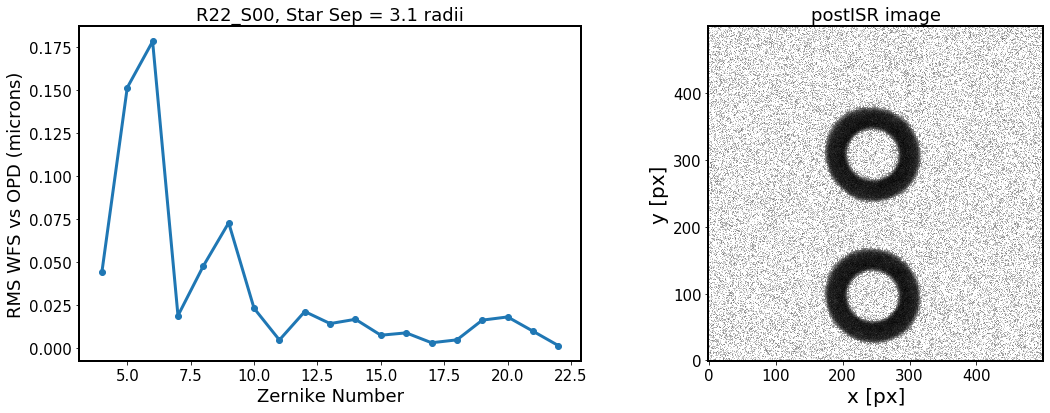

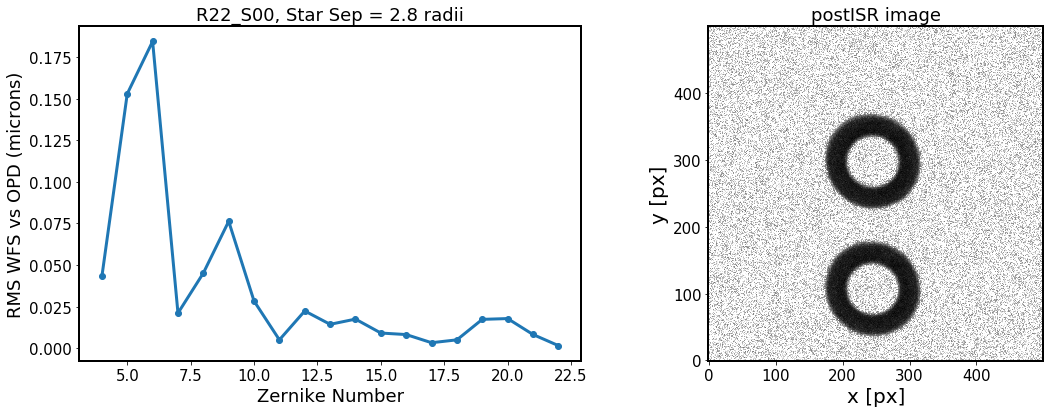

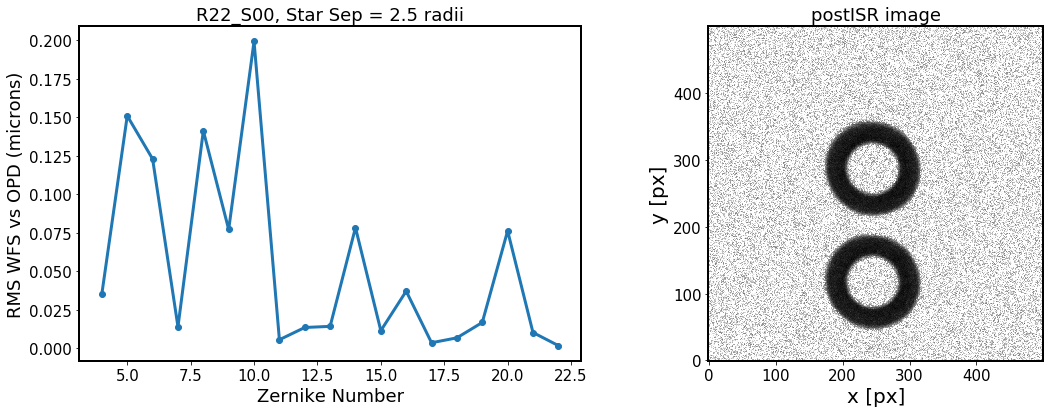

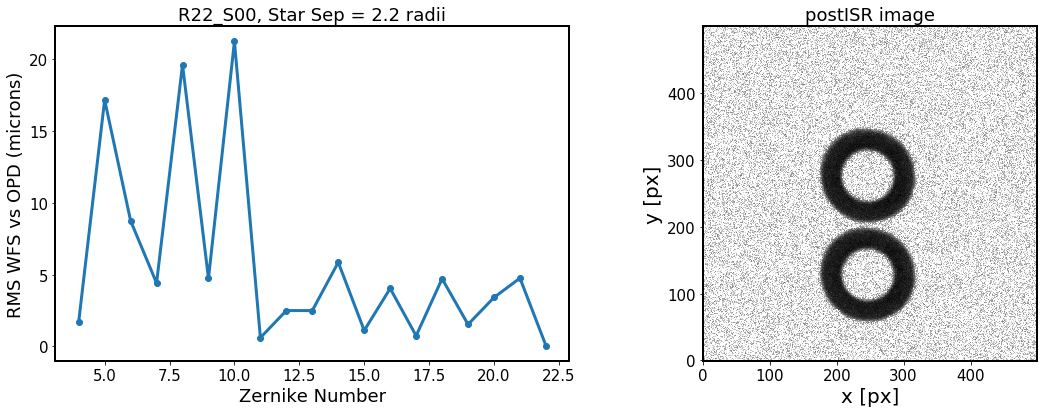

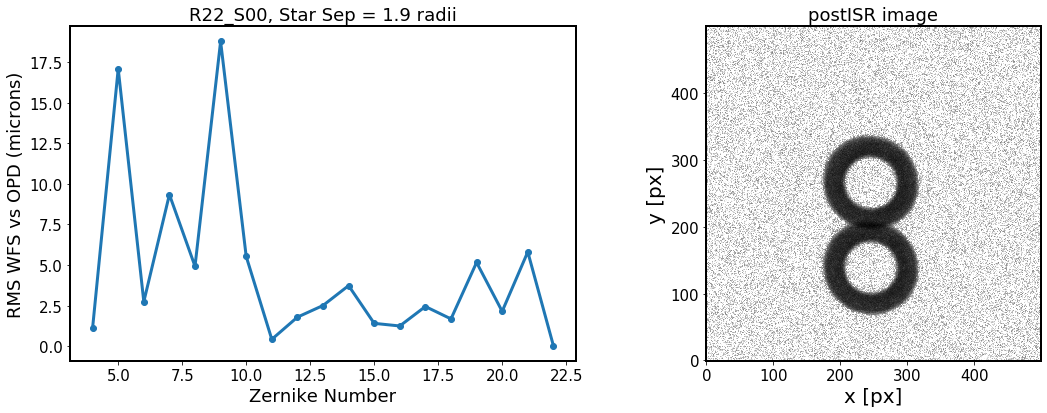

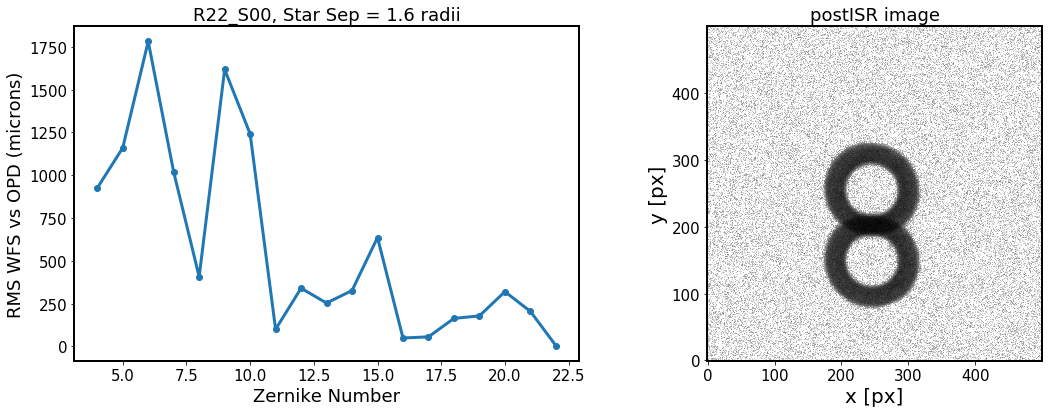

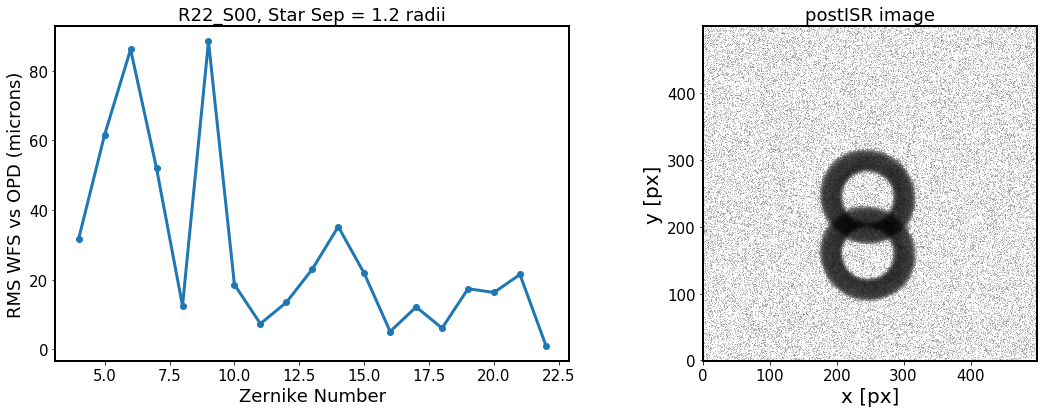

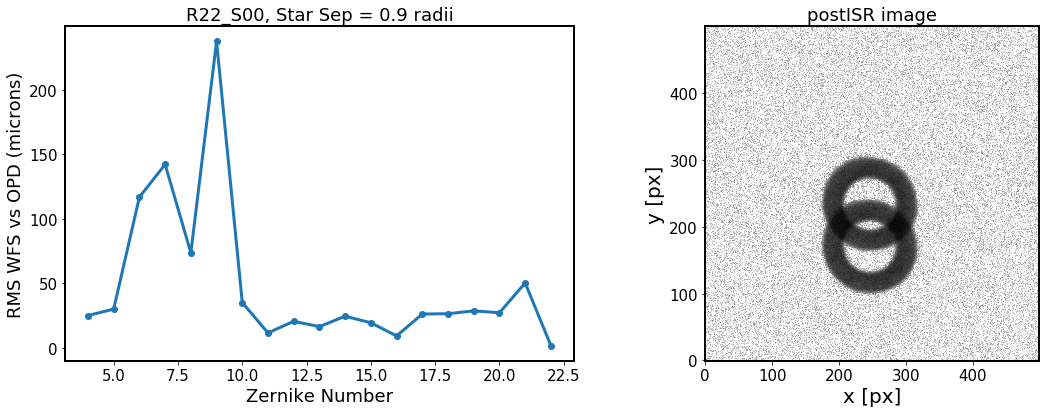

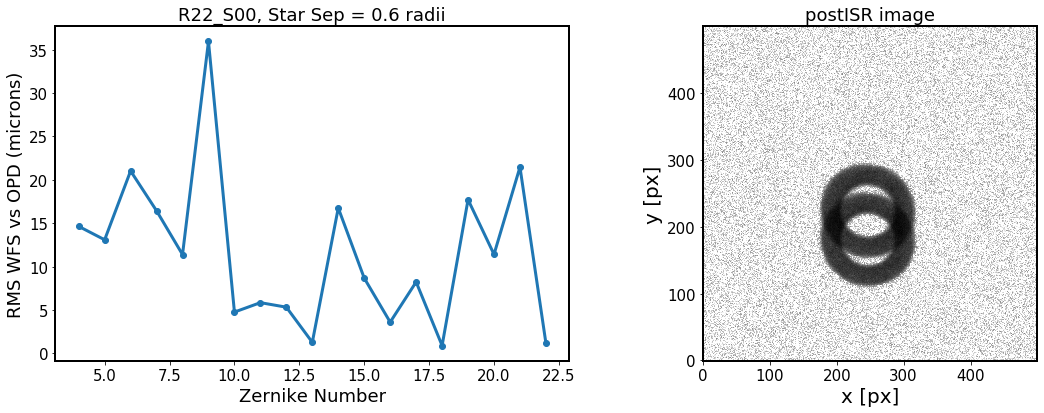

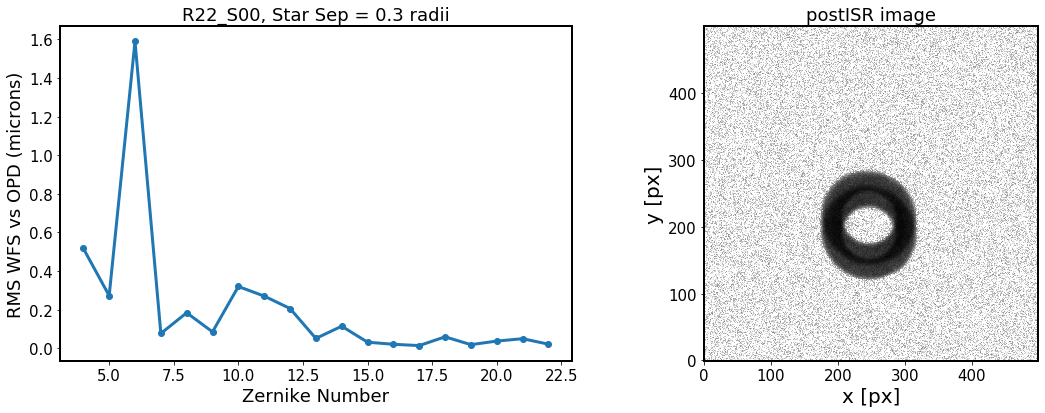

In [177]:
# print Zernikes and image data 

#  plot the Zernikes 
for i in range(len(sepArr)):
    
    sepInPerc = sepArr[i]
    rmsErrors = np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i])
    image = images[sepInPerc]
    
    at.plotZernikesAndCCD(image, rmsErrors, sepInPerc , xlims=[1525,2025], ylims=[750,1250],
                      sensor = 'R22_S00')


Plot the postage stamp images at different stages : 

0.9309090909090909
Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSepNew/sep_3/postage
extra_singleSciImg_sensor-R22_S02_star-0_id-4_posX-787_posY-1616.txt
extra_singleSciImg_sensor-R22_S02_star-1_id-5_posX-787_posY-1616.txt
extra_imgDeblend_full_sensor-R22_S02_star-0_id-4_posX-787_posY-1616.txt
extra_imgDeblend_full_sensor-R22_S02_star-1_id-5_posX-787_posY-1616.txt
extra_imgDeblend_resized_sensor-R22_S02_star-0_id-4_posX-787_posY-1616.txt
extra_imgDeblend_resized_sensor-R22_S02_star-1_id-5_posX-787_posY-1616.txt


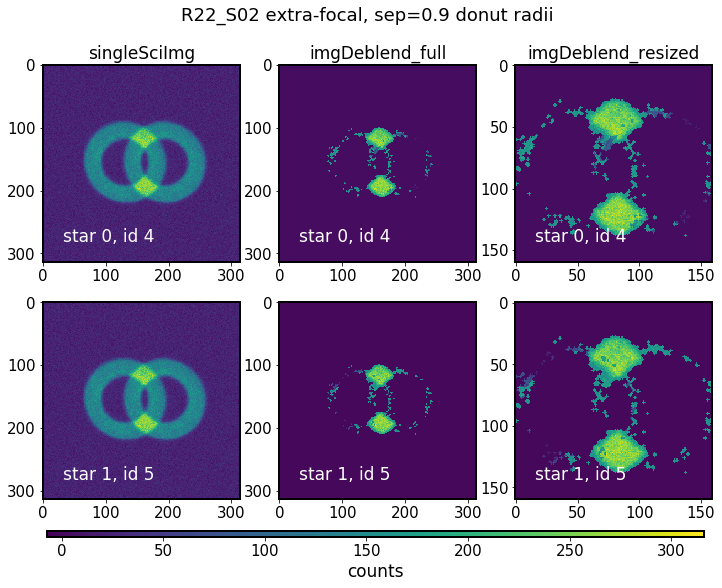

In [268]:
sensor='R22_S02'; focalType='extra'; sep=3
data_dir = os.path.join(baseDir, topDir,resDir, 'sep_%d' % sep)
sepInRadii = sepInPercToRadii(sep)
print(sepInRadii)
at.plotPostageStamps(data_dir, sensor=sensor, focalType=focalType, Nstars=2,
                     sepInRadii=sepInRadii
                  )
